# Analysis of model performances on pre/post ambiguity gridsearch

In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
grid_dict = {}
grid_dir = '/neurospin/dico/lguillon/distmap/gridsearch_lr5e-4/'
for folder in os.listdir(grid_dir):
    if 'n_' in folder:
        if os.path.isfile(os.path.join(grid_dir, folder, 'results_test.json')):
            n = re.search('n_([\d]{1,3})', folder).group(1)
            kl = re.search('kl_([\d]{1,2})', folder).group(1)
            with open(os.path.join(grid_dir, folder, 'results_test.json'), 'r') as f:
                grid_dict[(int(n), int(kl))] = json.load(f)

In [3]:
n_list = [list(grid_dict.keys())[k][0] for k in range(len(grid_dict))]
kl_list = [list(grid_dict.keys())[k][1] for k in range(len(grid_dict))]
loss = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['final_loss_val'][0] for i in range(len(grid_dict))]
gb = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['gb_pre'] for i in range(len(grid_dict))]
logreg = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['logreg_pre'] for i in range(len(grid_dict))]
svm = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['svm_pre'] for i in range(len(grid_dict))]

In [4]:
grid_df = pd.DataFrame(list(zip(n_list, kl_list, loss, gb, logreg, svm)), columns=['n', 'kl', 'loss', 'gb','logreg', 'svm'])

In [5]:
grid_df['mean_classif'] = list((grid_df.gb + grid_df.logreg + grid_df.svm)/3)

In [7]:
grid_df[['n', 'kl', 'loss', 'logreg']].sort_values(by=['logreg', 'loss'], ascending=[False, True])

,n,kl,loss,logreg
19,75,2,15431.062837,1.000000
12,150,4,16777.611485,1.000000
13,50,2,16829.031331,1.000000
17,100,4,17165.892904,1.000000
27,100,10,21529.536063,1.000000
8,100,8,20207.614037,0.989899
16,150,8,20450.873047,0.989899
6,40,2,17456.866269,0.989880
25,40,8,20816.982306,0.989861
14,75,10,21088.715030,0.989861


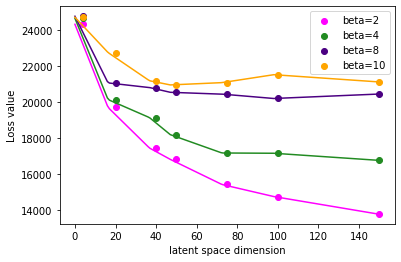

In [45]:
colors = {2: 'magenta', 4: 'forestgreen', 8: 'indigo', 10: 'orange'}
plt.subplot()

for b in [2, 4, 8, 10]:
    list_n = list(grid_df[grid_df.kl==b].n)
    list_loss = list(grid_df[grid_df.kl==b].loss)
    x_new = np.linspace(np.array(list_n).min(), np.array(list_n).max(),150)
    f = interp1d(list_n, list_loss, kind='linear')
    y_smooth=f(x_new)
    plt.scatter(list_n, list_loss, color=colors[b], label=f"beta={b}")
    plt.plot(y_smooth, color=colors[b])

plt.xlabel('latent space dimension')
plt.ylabel('Loss value')
plt.legend()
plt.show()

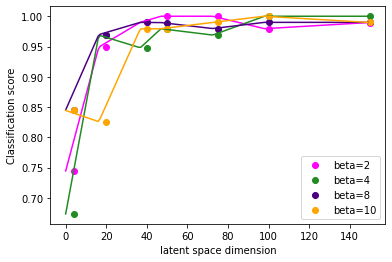

In [44]:
colors = {2: 'magenta', 4: 'forestgreen', 8: 'indigo', 10: 'orange'}
plt.subplot()

for b in [2, 4, 8, 10]:
    list_n = list(grid_df[grid_df.kl==b].n)
    list_loss = list(grid_df[grid_df.kl==b].logreg)
    x_new = np.linspace(np.array(list_n).min(), np.array(list_n).max(),150)
    f = interp1d(list_n, list_loss, kind='linear')
    y_smooth=f(x_new)
    plt.scatter(list_n, list_loss, color=colors[b], label=f"beta={b}")
    plt.plot(y_smooth, color=colors[b])

plt.xlabel('latent space dimension')
plt.ylabel('Classification score')
plt.legend()
plt.show()

#### Model choice
...

In [3]:
if torch.cuda.is_available():
    device = "cuda:0"

In [4]:
model_dir = '/neurospin/dico/lguillon/distmap/gridsearch_lr5e-4/n_75_kl_2/checkpoint.pt'
#model_dir = '/neurospin/dico/lguillon/distmap/checkpoint.pt'
model = VAE((1, 80, 80, 96), 75, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

### Data

In [5]:
data_dir = "/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/"
df_encoded_hcp = pd.read_pickle(os.path.join(data_dir, "encoded_hcp.pkl"))
#df_encoded_oh = pd.read_pickle(os.path.join(data_dir, "encoded_oh.pkl"))
#aims_data = pd.read_pickle(os.path.join(data_dir, "encoded_aims.pkl"))

### Analysis of latent space

#### Reduced space - TSNE / UMAP

In [6]:
X_hcp = np.array(list(df_encoded_hcp['latent']))
labels_hcp = np.array(df_encoded_hcp['Group'])

from sklearn.manifold import TSNE
X_embedded_hcp = TSNE(n_components=2, random_state=12, perplexity=40).fit_transform(X_hcp)

In [7]:
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
subjects_name_hcp = ['' for k in range(200)] + list(df_encoded_hcp[-7:]['sub'])

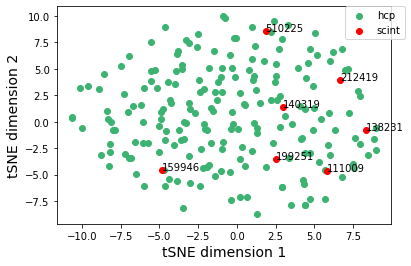

In [8]:
arr = X_embedded_hcp
color_dict = {'hcp':'mediumseagreen', 'scint': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

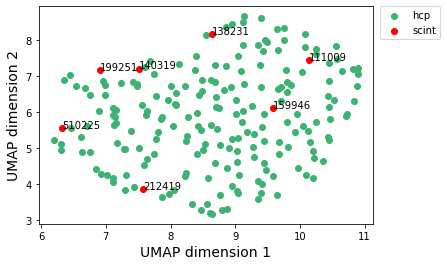

In [8]:
reducer = umap.UMAP(random_state=2)
embedding = reducer.fit_transform(X_hcp)

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [embedding[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (embedding[i][0], embedding[i][1]))
    
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Female / male

In [5]:
hcp_data = pd.read_csv('/neurospin/dico/lguillon/hcp_info/participants.csv')
hcp_data['Subject'] = hcp_data.astype(str)
hcp_data.head()

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


In [22]:
df_encoded_hcp['sub'] = df_encoded_hcp['sub'].astype(str)
gender_data = pd.merge(hcp_data, df_encoded_hcp, left_on='Subject', right_on='sub')[['latent', 'loss', 'recon', 'input', 'Group', 'sub', 'Subject', 'Gender']]

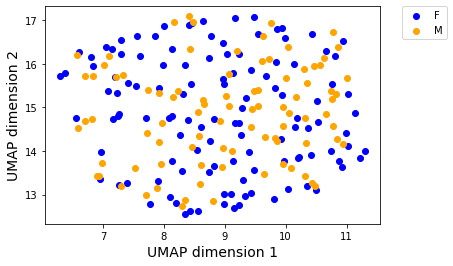

In [9]:
X_gender = np.array(list(gender_data['latent']))
labels_gender = np.array(list(gender_data['Gender']))

reducer = umap.UMAP(random_state=2)
embedding = reducer.fit_transform(X_gender)

color_dict = {'M':'orange', 'F': 'blue'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_gender):
    ix = np.where(labels_gender == g)
    x = [embedding[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### With all subjects

In [5]:
data_dir = '/neurospin/dico/lguillon/distmap/data/'
filenames_all = np.load(os.path.join(data_dir,
                                "train_sub_id.npy"))
distmaps = np.load(os.path.join(data_dir,
                                "train_distmap.npy"),
                       mmap_mode='r')

subset_sc = SkeletonDataset(dataframe=distmaps, filenames=filenames_all, data_transforms=False)
sc_loader = torch.utils.data.DataLoader(
                          subset_sc,
                          batch_size=8,
                          num_workers=8,
                          shuffle=False)

In [6]:
criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders={'hcp_train': sc_loader},
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp_all = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
losses_hcp_all = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
recon_hcp_all = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
input_hcp_all = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
var_hcp_all = {loader_name:[results_hcp[loader_name][k][4] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}

df_encoded_hcp_all = pd.DataFrame()
df_encoded_hcp_all['latent'] = encoded_hcp_all['hcp_train']
df_encoded_hcp_all['loss'] = losses_hcp_all['hcp_train']
df_encoded_hcp_all['recon'] = recon_hcp_all['hcp_train']
df_encoded_hcp_all['input'] = input_hcp_all['hcp_train']
df_encoded_hcp_all['var'] = var_hcp_all['hcp_train']
df_encoded_hcp_all['Group'] = ['hcp_train' for k in range(len(filenames_all))] 
df_encoded_hcp_all['sub'] = list(filenames_all)

hcp_train
ici
ici
ici
(1, 78, 63, 88, 1)
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
(1, 78, 63, 88, 1)
(78, 63, 88)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
ici
(1, 78, 63, 88, 1)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(78, 63, 88)
(78, 63, 88)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(1, 78, 63, 88, 1)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
ici
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(78, 63, 88)
(1, 78,

(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
[0.0000000e+00 2.3365021e-05 3.3617020e-05 ... 9.9994659e-01 9.9995196e-01
 9.9998927e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(78, 63, 88, 1)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78

(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
ici
(1, 78, 63, 88, 1)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
[0.0000000e+00 7.8678131e-06 8.3446503e-06 ... 9.9988401e-01 9.9989319e-01
 9.9997866e-01]
(78, 63, 88)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
[0.0000000e+

ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 4.1484833e-05 4.1961670e-05 ... 9.9983978e-01 9.9993062e-01
 9.9996853e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.3140182e-05 3.9339066e-05 ... 9.9991453e-01 9.9994659e-01
 9.9996793e-01]
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0

[0.0000000e+00 1.3589859e-05 1.4543533e-05 ... 9.9983442e-01 9.9989855e-01
 9.9997866e-01]
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)

(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.2424927e-05 3.3617020e-05 ... 9.9990392e-01 9.9992526e-01
 9.9998927e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 4.5537949e-05 6.1035156e-05 ... 

ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 6.1988831e-06 8.5830688e-06 ... 9.9989855e-01 9.9990392e-01
 9.9997866e-01]
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
[0.0000000e+00 2.3126602e-05 2.3841858e-05 ... 9.9994659e-01 9.9995196e-01
 9.9995720e-01]
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(7

(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
ici
(1, 78, 63, 88, 1)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63

In [7]:
subject_dir = "/neurospin/dico/lguillon/distmap/data/"
data_dir = "/neurospin/dico/lguillon/distmap/data/"
test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))
distmaps = np.load(os.path.join(data_dir, "test_distmap.npy"),
                   mmap_mode='r')
filenames = np.load(os.path.join(data_dir, "test_sub_id.npy"))
print(distmaps.shape, filenames.shape)

subset = SkeletonDataset(dataframe=distmaps,
                         filenames=filenames,
                         data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
scint_arr = np.array(['111009', '138231', '510225', '199251', '159946', '140319', '212419'])
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask/Rdistmaps"

distmaps_scint = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_scint = np.load(os.path.join(data_dir, "sub_id.npy"))

ids = np.frompyfunc(lambda x: np.isin(x, scint_arr), 1, 1)(filenames_scint)
idxs = [i for i, curr in enumerate(ids) if curr.any()]

filenames_scint = filenames_scint[idxs]
distmaps_scint = distmaps_scint[idxs]

print(distmaps_scint.shape, filenames_scint.shape)

subset_scint = SkeletonDataset(dataframe=distmaps_scint,
                         filenames=filenames_scint,
                         data_transforms=False)
scint_loader = torch.utils.data.DataLoader(
               subset_scint,
               batch_size=1,
               num_workers=1,
               shuffle=False)

dico_set_loaders_hcp = {'hcp': testloader, 'scint': scint_loader}

root_dir = '/neurospin/dico/lguillon/distmap/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders=dico_set_loaders_hcp,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
losses_hcp = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
recon_hcp = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
input_hcp = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
var_hcp = {loader_name:[results_hcp[loader_name][k][4] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}

df_encoded_hcp = pd.DataFrame()
df_encoded_hcp['latent'] = encoded_hcp['hcp'] + encoded_hcp['scint']
df_encoded_hcp['loss'] = losses_hcp['hcp'] + losses_hcp['scint']
df_encoded_hcp['recon'] = recon_hcp['hcp'] + recon_hcp['scint']
df_encoded_hcp['input'] = input_hcp['hcp'] + input_hcp['scint']
df_encoded_hcp['var'] = var_hcp['hcp'] + var_hcp['scint']
df_encoded_hcp['Group'] = ['hcp' for k in range(len(filenames))] + ['scint' for k in range(len(filenames_scint))]
df_encoded_hcp['sub'] = list(filenames) + list(filenames_scint)

(200, 78, 63, 88, 1) (200,)
(7, 78, 63, 88, 1) (7,)
hcp
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
[0.0000000e+00 2.8610229e-06 5.2452087e-06 ... 9.9908316e-01 9.9935913e-01
 9.9955142e-01]
[0.0000000e+00 1.6450882e-05 1.6689301e-05 ... 9.9897456e-01 9.9975324e-01
 9.9990916e-01]
[0.0000000e+00 1.7642975e-05 2.4557114e-05 ... 9.9955142e-01 9.9978638e-01
 9.9981844e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.000000e+00 9.083748e-05 9.703636e-05 ... 9.985260e-01 9.986541e-01
 9.996475e-01]
[0.0000000e+00 7.6055527e-05 9.8228455e-05 ... 9.9942851e-01 9.9949801e-01
 9.9971688e-01]
[0.0000000e+00 1.4615059e-04 1.6379356e-04 ... 9.9816823e-01 9.986060

(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.8930435e-04 1.9669533e-04 ... 9.9945009e-01 9.9981844e-01
 9.9992430e-01]
[0.0000000e+00 2.1672249e-04 2.3865700e-04 ... 9.9953008e-01 9.9961019e-01
 9.9998927e-01]
[0.0000000e+00 4.2676926e-05 6.4373016e-05 ... 9.9908841e-01 9.9947536e-01
 9.9996257e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.00000000e+00 1.14917755e-04 1.35660172e-04 ... 9.99967933e-01
 9.99973297e-01 9.99989271e-01]
[0.00000000e+00 1.09195709e-04 1.20162964e-04 ... 9.97842431e-01
 9.98130798e-01 9.98269677e-01]
[0.0000000e+00 5.0067902e-06 6.1988831e-06 ... 9.9937522e-01 9.9970090e-01
 9.9987185e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)


(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 5.4597855e-05 6.1035156e-05 ... 9.9947667e-01 9.9948728e-01
 9.9949801e-01]
[0.0000000e+00 3.9339066e-05 4.1723251e-05 ... 9.9856639e-01 9.9872887e-01
 9.9962616e-01]
[0.0000000e+00 1.5497208e-05 1.7642975e-05 ... 9.9912417e-01 9.9927366e-01
 9.9957907e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.4127960e-04 2.4199486e-04 ... 9.9941254e-01 9.9962616e-01
 9.9975431e-01]
[0.00000000e+00 1.21593475e-04 1.80244446e-04 ... 9.99412537e-01
 9.99492645e-01 9.99754310e-01]
[0.0000000e+00 2.2888184e-05 2.8848648e-05 ... 9.9898565e-01 9.9915087e-01
 9.9921489e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 6

(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.3855438e-05 4.1961670e-05 ... 9.9848330e-01 9.9868631e-01
 9.9904704e-01]
[0.0000000e+00 2.0265579e-05 2.0742416e-05 ... 9.9959409e-01 9.9971163e-01
 9.9976504e-01]
[0.0000000e+00 9.3460083e-05 9.5129013e-05 ... 9.9902391e-01 9.9915707e-01
 9.9951935e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.6927719e-05 2.0503998e-05 ... 9.9932706e-01 9.9954605e-01
 9.9982381e-01]
[0.0000000e+00 1.4543533e-04 1.5544891e-04 ... 9.9937522e-01 9.9950337e-01
 9.9983978e-01]
[0.0000000e+00 2.9325485e-05 3.9100647e-05 ... 9.9914551e-01 9.9915624e-01
 9.9925232e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)

### Latent space metrics (cf article by Ana Lawry Aguila)

In [8]:
mean_ctrl =  [np.mean([encoded_hcp_all['hcp_train'][k][i] for k in range(len(filenames_all))]) for i in range(75)]
#var_ctrl =  [np.mean([var_hcp_all['hcp_train'][k][i] for k in range(len(filenames_all))]) for i in range(75)]

var_ctrl =  [np.var([encoded_hcp_all['hcp_train'][k][i] for k in range(len(filenames_all))]) for i in range(75)]

In [25]:
import math

In [11]:
def dev(latent_sub, var_sub):
    """
    """
    n = len(latent_sub)
    mean_ctrl = [np.mean([encoded_hcp_all['hcp_train'][k][i] for k in range(801)]) for i in range(n)]
    var_ctrl = [np.mean([var_hcp_all['hcp_train'][k][i] for k in range(801)]) for i in range(n)]
    #var_ctrl =  [np.var([encoded_hcp_all['hcp_train'][k][i] for k in range(801)]) for i in range(75)]
    deviations = []
    
    for k in range(n):
        deviations.append(abs(latent_sub[k] - mean_ctrl[k])/np.sqrt(var_ctrl[k]+var_sub[k]))
    return(np.mean(deviations))

In [12]:
dev_test = [dev(encoded_hcp['hcp'][k], var_hcp['hcp'][k]) for k in range(200)]
dev_scint = [dev(encoded_hcp['scint'][k], var_hcp['scint'][k]) for k in range(7)]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3046008a20>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3046013d68>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3049fc8630>,
 'medians': [<matplotlib.lines.Line2D at 0x7f304602a358>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f304602a630>,
 'means': []}

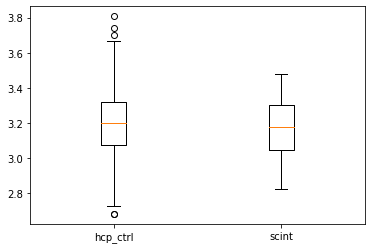

In [13]:
plt.boxplot((dev_test,dev_scint),
            labels=('hcp_ctrl','scint'))

In [14]:
F,p = mannwhitneyu(dev_test, dev_scint)
print(p)

0.35602065976406555


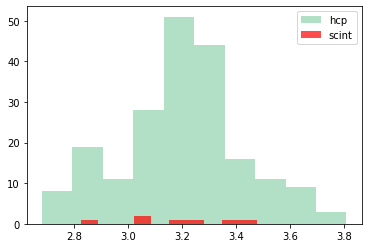

In [15]:
plt.subplot()
plt.hist(dev_test, color='mediumseagreen', alpha=0.4, label='hcp')
plt.hist(dev_scint, color='r', alpha=0.7, label='scint')
plt.legend()

### Classic analysis

In [75]:
X_train = np.array(list(df_encoded_hcp_all['latent']))
labels_train = np.array(df_encoded_hcp_all['Group'])

In [76]:
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(np.concatenate((X_train, X_hcp)))
embedding_test = reducer.transform(X_hcp)

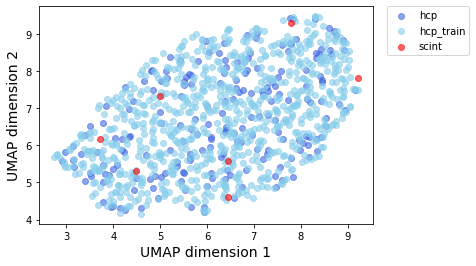

In [77]:
color_dict = {'hcp_train':'skyblue', 'hcp':'royalblue', 'scint': 'red'}

labels_all = np.concatenate((labels_train, labels_hcp))

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [embedding_all[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding_all[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=0.6)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [78]:
reducer = umap.UMAP()
embedding_train = reducer.fit_transform(X_train)
embedding_test = reducer.transform(X_hcp)

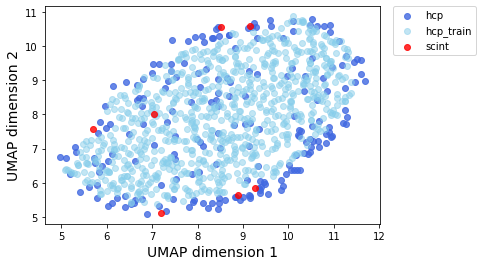

In [83]:
color_dict = {'hcp_train':'skyblue', 'hcp':'royalblue', 'scint': 'red'}

embedding_all = np.concatenate((embedding_train, embedding_test))
labels_all = np.concatenate((labels_train, labels_hcp))

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [embedding_all[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding_all[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp_train':
        ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=0.5)
    else:
        ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=0.8)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Outlier detection ML algorithm

In [10]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_hcp)

In [11]:
fp_list = {'oc':[], 'lof':[], 'if':[]}
tp_list = {'oc':[], 'lof':[], 'if':[]}
undetected_sub_oc = []
undetected_sub_if = []
fp_random = {}
tp_random = {}

for k in np.arange(0.05, 1, 0.01):
    tp_random[k] = []
    fp_random[k] = []
    clf = OneClassSVM(nu=k).fit(embedding)
    pred_ctrl = clf.predict(embedding)[:200]
    pred_scint = clf.predict(embedding)[200:]
    fp_list['oc'].append(len(pred_ctrl[pred_ctrl==-1])/200)
    tp_list['oc'].append(len(pred_scint[pred_scint==-1])/7)
    undetected_sub_oc.append(np.where(pred_scint[pred_scint==1]))
    nb_outliers = len(clf.predict(embedding)[clf.predict(embedding)==-1])
    for i in range(1000):
        rand_outliers = np.array(random.sample(range(207), nb_outliers))
        tp_random[k].append(len(rand_outliers[rand_outliers>=200])/7)
        fp_random[k].append(len(rand_outliers[rand_outliers<200])/200)

    
    clf = IsolationForest(random_state=10, contamination=k).fit(embedding)
    pred_ctrl = clf.predict(embedding)[:200]
    pred_scint = clf.predict(embedding)[200:]
    fp_list['if'].append(len(pred_ctrl[pred_ctrl==-1])/200)
    tp_list['if'].append(len(pred_scint[pred_scint==-1])/7)
    undetected_sub_if.append(np.where(pred_scint[pred_scint==1]))

In [12]:
mean_random_fp = [np.mean(fp_random[k]) for k in fp_random.keys()]
mean_random_tp = [np.mean(tp_random[k]) for k in tp_random.keys()]

quantile_5_random_fp = [np.quantile(fp_random[k], 0.05) for k in fp_random.keys()]
quantile_5_random_tp = [np.quantile(tp_random[k], 0.05) for k in tp_random.keys()]

quantile_95_random_fp = [np.quantile(fp_random[k], 0.95) for k in fp_random.keys()]
quantile_95_random_tp = [np.quantile(tp_random[k], 0.95) for k in tp_random.keys()]

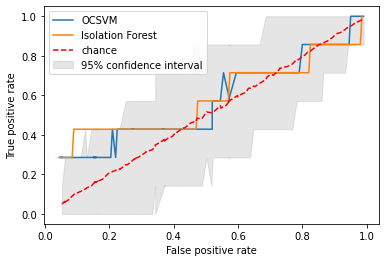

In [13]:
plt.subplot()
plt.plot(fp_list['oc'], tp_list['oc'], label='OCSVM')
plt.plot(fp_list['if'], tp_list['if'], label='Isolation Forest')

plt.plot(mean_random_fp, mean_random_tp, linestyle='--', label='chance', c='r')
#plt.plot(quantile_5_random_fp, quantile_5_random_tp, label='5th quantile')
#plt.plot(quantile_95_random_fp, quantile_95_random_tp, label='95th percentile')

plt.fill_between(mean_random_fp, quantile_5_random_tp, quantile_95_random_tp, color='grey', alpha=.2,
            label=f"95% confidence interval")


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

In [13]:
average_fp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}
average_tp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}

for k in range(10):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(X_hcp)
    fp_list = {'oc':[], 'lof':[], 'if':[]}
    tp_list = {'oc':[], 'lof':[], 'if':[]}
    undetected_sub_oc = []
    undetected_sub_if = []
    fp_random = {}
    tp_random = {}

    for k in np.arange(0.05, 1, 0.1):
        tp_random[k] = []
        fp_random[k] = []
        clf = OneClassSVM(nu=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]
        #fp_list['oc'].append(len(pred_ctrl[pred_ctrl==-1])/200)
        #tp_list['oc'].append(len(pred_scint[pred_scint==-1])/7)
        
        average_fp_list['oc'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['oc'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_oc.append(np.where(pred_scint==1))
        nb_outliers = len(clf.predict(embedding)[clf.predict(embedding)==-1])

        clf = IsolationForest(random_state=10, contamination=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]
        
        average_fp_list['if'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['if'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_if.append(np.where(pred_scint==1))
        
        for i in range(1000):
            rand_outliers = np.array(random.sample(range(207), nb_outliers))
            tp_random[k].append(len(rand_outliers[rand_outliers>=200])/7)
            fp_random[k].append(len(rand_outliers[rand_outliers<200])/200)
        
        
mean_random_fp = [np.mean(fp_random[k]) for k in fp_random.keys()]
mean_random_tp = [np.mean(tp_random[k]) for k in tp_random.keys()]

quantile_5_random_fp = [np.quantile(fp_random[k], 0.05) for k in fp_random.keys()]
quantile_5_random_tp = [np.quantile(tp_random[k], 0.05) for k in tp_random.keys()]

quantile_95_random_fp = [np.quantile(fp_random[k], 0.95) for k in fp_random.keys()]
quantile_95_random_tp = [np.quantile(tp_random[k], 0.95) for k in tp_random.keys()]

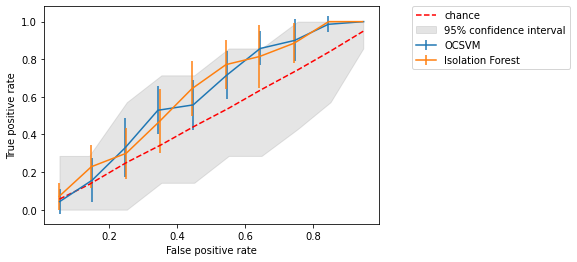

In [14]:
fp_oc = [np.mean(average_fp_list['oc'][k]) for k in average_fp_list['oc'].keys()]
tp_oc = [np.mean(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
error_oc = [np.std(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
fp_if = [np.mean(average_fp_list['if'][k]) for k in average_fp_list['if'].keys()]
tp_if = [np.mean(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]
error_if = [np.std(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]

plt.subplot()
plt.errorbar(fp_oc, tp_oc, yerr=error_oc,label='OCSVM')
plt.errorbar(fp_if, tp_if, yerr=error_if, label='Isolation Forest')

plt.plot(mean_random_fp, mean_random_tp, linestyle='--', label='chance', c='r')
plt.fill_between(mean_random_fp, quantile_5_random_tp, quantile_95_random_tp, color='grey', alpha=.2,
            label=f"95% confidence interval")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(bbox_to_anchor=(1.1,1), borderaxespad=0)
#plt.legend()
plt.show()

### Which interrupted CS are missing ?

In [15]:
undetected_sub_oc

[(array([0, 1, 2, 3, 4, 5]),),
 (array([0, 1, 2, 5]),),
 (array([0, 1, 2, 5]),),
 (array([0, 2, 5]),),
 (array([0, 2, 5]),),
 (array([5]),),
 (array([5]),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),)]

In [16]:
df_encoded_hcp.loc[[200, 202, 205]]

,latent,loss,recon,input,Group,sub
200,"[-0.5108173, -1.3633481, 0.0028913165, -0.6194...",2506,2236,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,138231
202,"[-0.082732975, -0.30004776, 1.8481869, 0.80898...",2577,2302,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,159946
205,"[0.798065, -0.7499985, 0.6710335, -1.9978501, ...",2032,1746,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,199251


### Which continuous CS are considered as outliers ?

In [131]:
for k in range(10):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(X_hcp)
    detected_sub_oc = []
    detected_sub_if = []

    for k in np.arange(0.05, 1, 0.1):
        tp_random[k] = []
        fp_random[k] = []
        clf = OneClassSVM(nu=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]
        detected_sub_oc.append(np.where(pred_ctrl==-1))

        clf = IsolationForest(random_state=10, contamination=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]      
        detected_sub_if.append(np.where(pred_ctrl==-1))

In [340]:
#detected_sub_oc

In [137]:
#detected_sub_if

8, 27, 160, 162, 92, 155, 41, 77, 122, 196

0, 2, 34, 43, 47,51, 52,91, 97, 100, 120,130, 135, 146,160, 162, 199

92, 155, 92

In [11]:
non_int_out = list(df_encoded_hcp.loc[[8, 27, 160, 162, 92, 155, 41, 77, 122, 196]]['sub'])

In [12]:
non_int_out

[679770,
 942658,
 268850,
 146331,
 185038,
 611938,
 116221,
 965367,
 176239,
 657659]

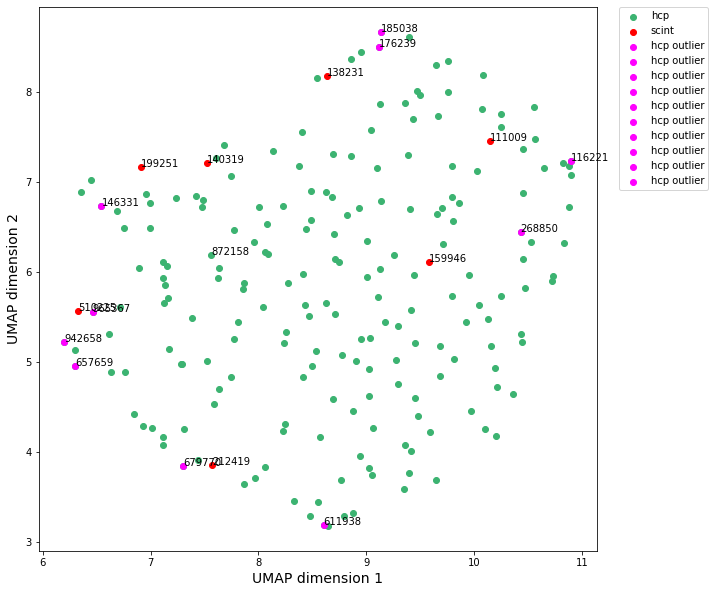

In [13]:
reducer = umap.UMAP(random_state=2)
embedding = reducer.fit_transform(X_hcp)

color_dict = {'hcp':'mediumseagreen', 'scint': 'red'}

fig = plt.figure(figsize=(10,10))
ax = fig.subplots()

ax.scatter([embedding[k][:200][0] for k in range(200)], [embedding[k][:200][1] for k in range(200)], c = color_dict['hcp'], label = 'hcp')
ax.scatter([embedding[k][0] for k in range(200, 207)], [embedding[k][1] for k in range(200, 207)], c = color_dict['scint'], label = 'scint')
    
for g in np.unique(non_int_out):
    ix = np.where(np.array(df_encoded_hcp['sub']) == g)
    x = [embedding[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = 'magenta', label = 'hcp outlier')
    

# now plot both limits against eachother
#ax.plot(ax.get_xlim(), ax.get_ylim(), 'k-', alpha=0.75)
for i, txt in enumerate(list(df_encoded_hcp['sub'])):
    if txt in non_int_out or txt in scint_list or txt in [872158]:
        ax.annotate(txt, (embedding[i][0], embedding[i][1]))
    
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [129]:
average_fp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}
average_tp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}

for k in range(10):
    fp_list = {'oc':[], 'lof':[], 'if':[]}
    tp_list = {'oc':[], 'lof':[], 'if':[]}
    undetected_sub_oc = []
    undetected_sub_if = []
    fp_random = {}
    tp_random = {}

    for k in np.arange(0.05, 1, 0.1):
        tp_random[k] = []
        fp_random[k] = []
        clf = OneClassSVM(nu=k).fit(X_hcp)
        pred_ctrl = clf.predict(X_hcp)[:200]
        pred_scint = clf.predict(X_hcp)[200:]
        #fp_list['oc'].append(len(pred_ctrl[pred_ctrl==-1])/200)
        #tp_list['oc'].append(len(pred_scint[pred_scint==-1])/7)
        
        average_fp_list['oc'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['oc'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_oc.append(np.where(pred_scint==1))
        nb_outliers = len(clf.predict(X_hcp)[clf.predict(X_hcp)==-1])

        clf = IsolationForest(random_state=10, contamination=k).fit(X_hcp)
        pred_ctrl = clf.predict(X_hcp)[:200]
        pred_scint = clf.predict(X_hcp)[200:]
        
        average_fp_list['if'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['if'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_if.append(np.where(pred_scint==1))
        
        for i in range(1000):
            rand_outliers = np.array(random.sample(range(207), nb_outliers))
            tp_random[k].append(len(rand_outliers[rand_outliers>=200])/7)
            fp_random[k].append(len(rand_outliers[rand_outliers<200])/200)
        
        
mean_random_fp = [np.mean(fp_random[k]) for k in fp_random.keys()]
mean_random_tp = [np.mean(tp_random[k]) for k in tp_random.keys()]

quantile_5_random_fp = [np.quantile(fp_random[k], 0.05) for k in fp_random.keys()]
quantile_5_random_tp = [np.quantile(tp_random[k], 0.05) for k in tp_random.keys()]

quantile_95_random_fp = [np.quantile(fp_random[k], 0.95) for k in fp_random.keys()]
quantile_95_random_tp = [np.quantile(tp_random[k], 0.95) for k in tp_random.keys()]

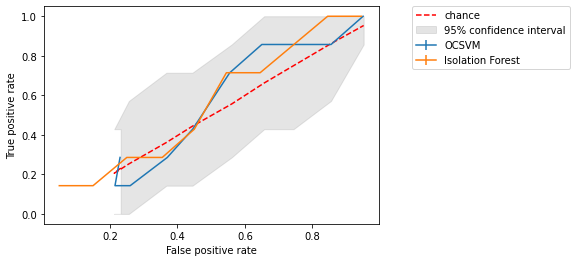

In [130]:
fp_oc = [np.mean(average_fp_list['oc'][k]) for k in average_fp_list['oc'].keys()]
tp_oc = [np.mean(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
error_oc = [np.std(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
fp_if = [np.mean(average_fp_list['if'][k]) for k in average_fp_list['if'].keys()]
tp_if = [np.mean(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]
error_if = [np.std(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]

plt.subplot()
plt.errorbar(fp_oc, tp_oc, yerr=error_oc,label='OCSVM')
plt.errorbar(fp_if, tp_if, yerr=error_if, label='Isolation Forest')

plt.plot(mean_random_fp, mean_random_tp, linestyle='--', label='chance', c='r')
plt.fill_between(mean_random_fp, quantile_5_random_tp, quantile_95_random_tp, color='grey', alpha=.2,
            label=f"95% confidence interval")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(bbox_to_anchor=(1.1,1), borderaxespad=0)
#plt.legend()
plt.show()

### Clusters ? 
how is the latent space organized ? 

For n_clusters = 2 The average silhouette_score with kmeans is : 0.3637127
For n_clusters = 3 The average silhouette_score with kmeans is : 0.3996799
For n_clusters = 4 The average silhouette_score with kmeans is : 0.37534034
For n_clusters = 5 The average silhouette_score with kmeans is : 0.36279878
For n_clusters = 6 The average silhouette_score with kmeans is : 0.35999566
For n_clusters = 7 The average silhouette_score with kmeans is : 0.37104797
For n_clusters = 8 The average silhouette_score with kmeans is : 0.37462077
For n_clusters = 9 The average silhouette_score with kmeans is : 0.37034982
For n_clusters = 10 The average silhouette_score with kmeans is : 0.36307368
For n_clusters = 11 The average silhouette_score with kmeans is : 0.37783918
For n_clusters = 12 The average silhouette_score with kmeans is : 0.37408957
For n_clusters = 13 The average silhouette_score with kmeans is : 0.3717357
For n_clusters = 14 The average silhouette_score with kmeans is : 0.3661108
For n_clust

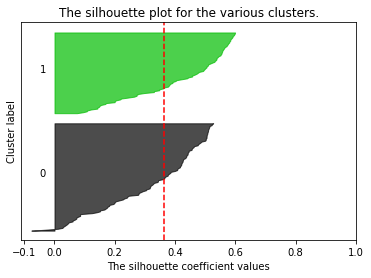

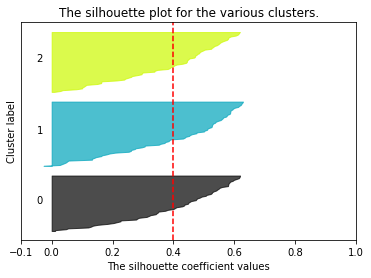

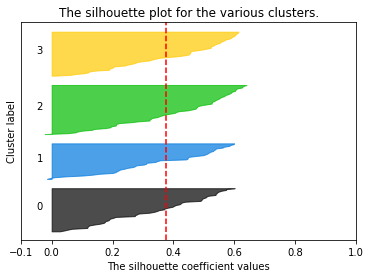

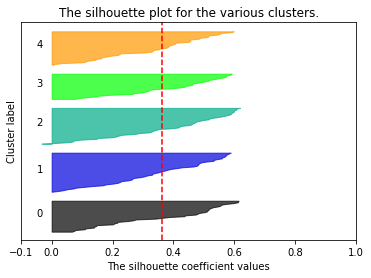

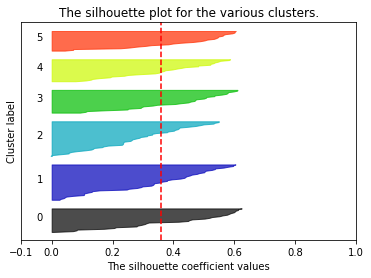

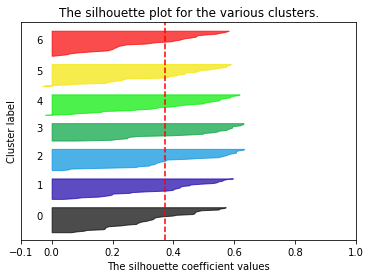

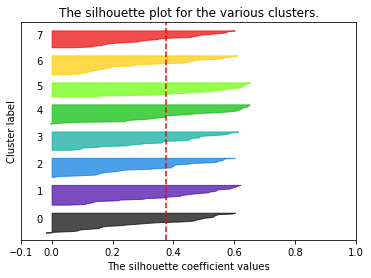

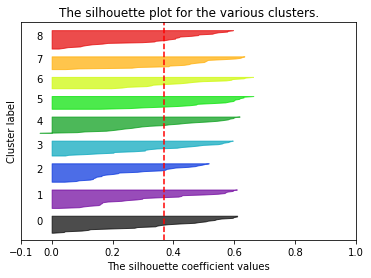

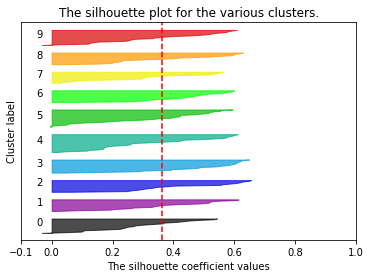

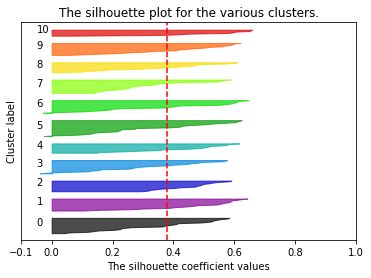

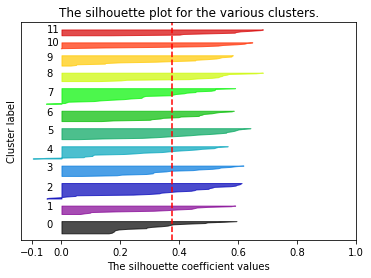

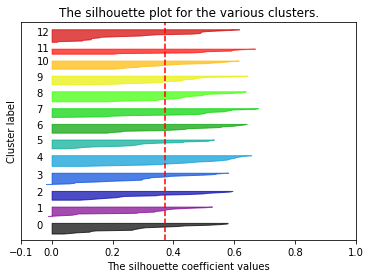

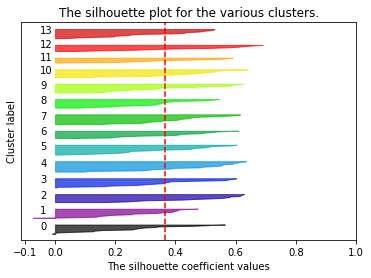

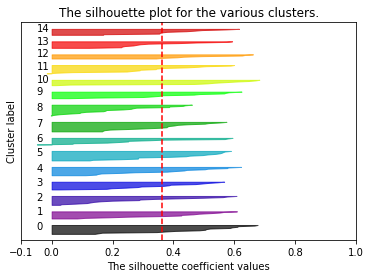

In [14]:
n_clusters_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n in n_clusters_list:
    cluster_labels= KMeans(n_clusters=n, random_state=0).fit_predict(embedding)

    fig, ax1 = plt.subplots()
    ax1.set_ylim([0, len(embedding) + (n + 1) * 10])
    silhouette_avg = silhouette_score(embedding, cluster_labels)
    print("For n_clusters =", n, "The average silhouette_score with kmeans is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(embedding, cluster_labels)

    y_lower = 10
    for i in range(n):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [15]:
af = AffinityPropagation(random_state=15, max_iter=1000).fit(embedding)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(embedding)
clusters_centroids = af.cluster_centers_
while n_clusters_ > 7:
    af = AffinityPropagation(random_state=0).fit(embedding[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(embedding)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

12
3
cluster's centroids coordinates: 
 [[9.6544    6.640173 ]
 [8.693859  4.5940285]
 [6.618083  5.31561  ]]


In [16]:
dstrb_clu = pd.DataFrame(embedding, index=list(df_encoded_hcp['sub'][:200]) + scint_list, columns=[1, 2])
dstrb_clu['cluster_lab'] = x_cluster_label

cluster1 = dstrb_clu[dstrb_clu.cluster_lab==0]
cluster2 = dstrb_clu[dstrb_clu.cluster_lab==1]
cluster3 = dstrb_clu[dstrb_clu.cluster_lab==2]
cluster4 = dstrb_clu[dstrb_clu.cluster_lab==3]

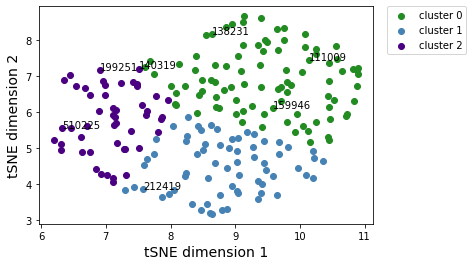

In [17]:
arr = np.array([np.array([dstrb_clu[k][i] for k in dstrb_clu.columns[:2]]) for i in range(len(dstrb_clu))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_clu.cluster_lab]):
    ix = np.where(dstrb_clu.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (embedding[i][0], embedding[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

### Distances to centroid

In [18]:
def centeroidnp(arr):
    length, dim = arr.shape
    return np.array([np.sum(arr[:, i])/length for i in range(dim)])

In [19]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [20]:
dstrb_sub_hcp = pd.DataFrame(X_hcp, index=list(df_encoded_hcp['sub']), columns=[k for k in range(1, len(df_encoded_hcp.latent[0])+1)])

In [21]:
dstrb_sub_hcp.head()

,1,2,3,4,5,6,7,8,9,10,...,66,67,68,69,70,71,72,73,74,75
932554,1.498768,-2.370979,-0.386633,-1.805903,-1.640908,0.889017,-0.788837,1.798124,-0.226252,2.262826,...,-0.102943,-2.583251,0.855373,-2.297728,0.038101,-0.507936,0.148095,-0.890834,0.816926,0.593571
387959,1.252402,1.641905,-0.835358,-0.126154,-0.787843,0.480225,-0.496849,-0.422218,1.169830,-0.576299,...,-0.195885,2.280522,1.421875,0.870732,0.323759,-0.757779,0.312783,0.208075,2.278088,1.087756
887373,-0.110672,0.174864,-0.850204,0.352294,2.037961,3.249742,0.055441,-1.478776,-1.323680,-2.021513,...,-0.471757,-0.544958,1.041807,-0.735108,-0.411240,0.858377,-2.503704,0.575416,-0.044089,1.783877
704238,-0.420137,1.120343,-0.158846,0.602574,-0.284027,-2.788037,0.835695,0.760048,1.396570,0.260587,...,-1.462170,-0.448359,1.350685,-0.714808,0.236187,2.234452,1.398382,-0.855307,-0.031911,-0.364948
169040,0.399484,2.767998,0.601121,-0.400000,0.480090,0.142670,-1.033846,1.149555,-0.549302,-0.302024,...,-1.297961,-0.018789,-0.645050,0.094646,-0.498234,-0.189802,-2.034818,0.823724,0.716479,-0.066602


In [22]:
centroid = closest_distance(centeroidnp(X_hcp), dstrb_sub_hcp)
print(centroid)

571144


In [23]:
dist_centroid_ctrl = [distance.cityblock(list(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].latent)[k], centroid) for k in range(len(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].latent))]
dist_centroid_scint = [distance.cityblock(list(df_encoded_hcp[df_encoded_hcp.Group=='scint'].latent)[k], centroid) for k in range(len(df_encoded_hcp[df_encoded_hcp.Group=='scint'].latent))]

In [24]:
F,p = mannwhitneyu(dist_centroid_ctrl, dist_centroid_scint)
print(p)

0.3254298432824096


In [25]:
""" In reduced space """
dstrb_sub_red = pd.DataFrame(X_embedded_hcp, index=list(df_encoded_hcp['sub']), columns=[1, 2])
centroid_red = closest_distance(centeroidnp(X_embedded_hcp), dstrb_sub_red)
print(centroid_red)
dist_centroid_ctrl_red = [distance.cityblock(X_embedded_hcp[k], centroid_red) for k in range(len(df_encoded_hcp[df_encoded_hcp.Group=='hcp']))]
dist_centroid_scint_red = [distance.cityblock(X_embedded_hcp[200+k], centroid_red) for k in range(len(df_encoded_hcp[df_encoded_hcp.Group=='scint']))]
F,p = mannwhitneyu(dist_centroid_ctrl_red, dist_centroid_scint_red)
print(p)

102311
0.09142565277837789


### Generation from centroid to point cloud parts

In [35]:
df_encoded_hcp['latent'][k_centroid]

array([ 2.4287229e+00,  9.1864610e-01,  1.3817806e+00, -1.7014818e+00,
        7.8640550e-01,  7.1760535e-01, -1.7038701e+00,  2.2088066e-01,
       -2.7567756e+00, -2.6345453e-01, -2.1878269e-01, -8.7773430e-01,
        1.7491435e-01,  1.6983638e+00,  1.6407160e-01,  2.2672458e+00,
       -2.4602060e+00,  2.4457350e-01,  8.3437210e-01, -1.4328322e+00,
       -1.5247579e-01,  5.6363136e-01, -2.8544438e-01, -1.0813529e+00,
        1.6056273e+00, -1.8105919e+00,  4.5422328e-01,  1.0814204e+00,
       -1.0377508e+00,  5.6735522e-01, -1.4586190e+00,  2.9412559e-01,
       -1.8630607e+00,  6.9745654e-01,  2.2000473e+00,  4.7853157e-01,
       -2.0620286e+00, -1.3084512e+00, -1.2234845e+00, -1.2878735e+00,
        9.6365482e-01,  4.2861957e-02, -2.0523715e+00, -1.6638201e+00,
       -7.8012519e-02,  9.1511220e-01,  1.0537411e+00,  1.6767716e+00,
       -1.0315847e+00, -1.1308869e+00,  6.0876781e-01,  2.0734856e+00,
       -1.5312744e+00, -2.1818106e+00,  1.1906798e+00,  1.7735783e+00,
      

In [27]:
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
scint_arr = np.array(['111009', '138231', '510225', '199251', '159946', '140319', '212419'])
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask/Rdistmaps"

distmaps_scint = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_scint = np.load(os.path.join(data_dir, "sub_id.npy"))

ids = np.frompyfunc(lambda x: np.isin(x, scint_arr), 1, 1)(filenames_scint)
idxs = [i for i, curr in enumerate(ids) if curr.any()]

filenames_scint = filenames_scint[idxs]
distmaps_scint = distmaps_scint[idxs]

print(distmaps_scint.shape, filenames_scint.shape)

subset_scint = SkeletonDataset(dataframe=distmaps_scint,
                         filenames=filenames_scint,
                         data_transforms=False)
scint_loader = torch.utils.data.DataLoader(
               subset_scint,
               batch_size=1,
               num_workers=1,
               shuffle=False)

dico_set_loaders_hcp = {'scint': scint_loader}

root_dir = '/neurospin/dico/lguillon/distmap/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders=dico_set_loaders_hcp,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
losses_hcp = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
recon_hcp = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
input_hcp = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}

(7, 78, 63, 88, 1) (7,)
scint
[0.0000000e+00 2.0742416e-05 3.2901764e-05 ... 9.9946594e-01 9.9947131e-01
 9.9949801e-01]
[0.0000000e+00 3.0994415e-06 4.0531158e-06 ... 9.9826968e-01 9.9914551e-01
 9.9953008e-01]
[0.0000000e+00 9.3936920e-05 1.0442734e-04 ... 9.9919891e-01 9.9944985e-01
 9.9973822e-01]
[0.0000000e+00 8.6069107e-05 9.0122223e-05 ... 9.9916887e-01 9.9929404e-01
 9.9999464e-01]
[0.000000e+00 3.337860e-05 3.528595e-05 ... 9.994670e-01 9.995514e-01
 9.996742e-01]
[0.0000000e+00 5.9127808e-05 6.3657761e-05 ... 9.9829638e-01 9.9859536e-01
 9.9939120e-01]
[0.0000000e+00 9.9420547e-05 1.2373924e-04 ... 9.9951279e-01 9.9979711e-01
 9.9989557e-01]


In [29]:
results_hcp['scint']

{'138231': (tensor(2735.2534, device='cuda:0'),
  array([-5.1081729e-01, -1.3633481e+00,  2.8913165e-03, -6.1942536e-01,
          1.5702767e+00,  1.2140783e+00,  2.6112735e-01,  2.6931100e+00,
         -1.1140893e+00,  3.6063915e-01, -3.1183696e-01,  7.8468651e-02,
         -3.0094445e+00, -8.3773369e-01,  1.8737460e+00, -6.1512786e-01,
          2.5019124e+00, -4.5796061e-01,  6.6279829e-01, -1.4978261e+00,
         -1.5474046e+00,  1.1144600e+00, -1.4525694e+00,  5.6681490e-01,
          3.5296357e-01, -1.3985479e+00, -1.1016154e-01, -9.6206021e-01,
          9.2260790e-01, -6.9265723e-02, -1.0678372e+00,  2.4681518e-02,
          9.7021073e-02,  1.0227327e+00, -1.0866112e+00,  8.9932197e-01,
          1.9846623e-01,  1.1632190e+00,  2.9794154e+00, -2.6287673e+00,
          1.4333665e+00,  7.6790333e-01,  6.8180382e-01, -4.4625407e-01,
         -4.1146368e-01,  1.1746444e+00, -1.1225159e+00, -4.3869612e-01,
          6.7724419e-01, -1.3141066e-03,  1.4340061e+00, -1.0574291e-01,
   

In [36]:
list(df_encoded_hcp[df_encoded_hcp['sub']=='138231'].latent)[0]==results_hcp['scint']['138231'][1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [28]:
enc = encoded_hcp['scint'][0]

z = torch.from_numpy(enc).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.4] = 1
out[out<=0.4] = 0
out = dtx.convert.volume_to_bucketMap_aims(out, voxel_size=(1,1,1))

aims.write(out, f"/tmp/test.bck")

In [38]:
k_centroid = int(np.where(df_encoded_hcp['sub']==centroid_red)[0])

enc = df_encoded_hcp['latent'][k_centroid]

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.4] = 1
out[out<=0.4] = 0
out = dtx.convert.volume_to_bucketMap_aims(out, voxel_size=(1,1,1))

aims.write(out, f"/tmp/test2.bck")

# error_map = df_encoded_hcp['input'][k_centroid] - out

# np.save(f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/through_latent_space/centroid_out.npy", out)
# np.save('/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/through_latent_space/centroid_input.npy', df_encoded_hcp['input'][k_centroid])
# np.save('/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/through_latent_space/centroid_error.npy', error_map)

In [39]:
k_flat = int(np.where(df_encoded_hcp['sub']==185038)[0])

enc = df_encoded_hcp['latent'][k_flat]

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())
error_map = df_encoded_hcp['input'][k_flat] - out

out[out>0.4] = 1
out[out<=0.4] = 0
out = dtx.convert.volume_to_bucketMap_aims(out, voxel_size=(1,1,1))

aims.write(out, f"/tmp/test3.bck")

# np.save(f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/through_latent_space/flat_out.npy", out)
# np.save('/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/through_latent_space/flat_input.npy', df_encoded_hcp['input'][k_flat])
# np.save('/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/through_latent_space/flat_error.npy', error_map)

In [27]:
import dico_toolbox as dtx

In [42]:
## From centroid to flat part
enc_0 = df_encoded_hcp['latent'][k_centroid]
enc_flat = df_encoded_hcp['latent'][k_flat]
arr_out = []

for k in range(1, 10):
    z = torch.from_numpy(np.array([enc_0[i] + ((enc_flat[i] - enc_0[i])/10)*k for i in range(len(enc_0))])).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.4] = 1
    out[out<=0.4] = 0
    arr_out.append(out)

for k in range(9):
    #aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/through_latent_space/interpolation_bucket_step_{k}.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(1,1,1)), f"/tmp/interpolation_bucket_step_{k}.bck")

In [259]:
## From centroid to open knob part
k_openKnob = int(np.where(df_encoded_hcp['sub']==611938)[0])

enc_centroid = df_encoded_hcp['latent'][k_centroid]
enc_open = df_encoded_hcp['latent'][k_openKnob]
arr_out = []

for k in range(1, 6):
    z = torch.from_numpy(np.array([enc_0[i] + ((enc_open[i] - enc_0[i])/6)*k for i in range(len(enc_0))])).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.5] = 1
    out[out<=0.5] = 0
    arr_out.append(out)

for k in range(len(arr_out)):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/open_knob_interpolation_bucket_step_{k}.bck")


In [39]:
k_openKnob = int(np.where(df_encoded_hcp['sub']==611938)[0])

In [40]:
enc = df_encoded_hcp['latent'][k_openKnob]

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())
out[out>0.5] = 1
out[out<=0.5] = 0
#aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/open_knob.bck")
aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/tmp/open_knob.bck")

In [410]:
## From centroid to triple part
k_triple = int(np.where(df_encoded_hcp['sub']==268850)[0])

enc_centroid = df_encoded_hcp['latent'][k_centroid]
enc_triple = df_encoded_hcp['latent'][k_triple]
arr_out = []

for k in range(1, 6):
    z = torch.from_numpy(np.array([enc_0[i] + ((enc_triple[i] - enc_0[i])/6)*k for i in range(len(enc_0))])).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.5] = 1
    out[out<=0.5] = 0
    arr_out.append(out)

for k in range(len(arr_out)):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/triple_bucket_step_{k}.bck")


In [263]:
enc = df_encoded_hcp['latent'][k_triple]

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())
out[out>0.5] = 1
out[out<=0.5] = 0
aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/triple.bck")

In [303]:
## From centroid to left part
k_left = int(np.where(df_encoded_hcp['sub']==942658)[0])

enc_centroid = df_encoded_hcp['latent'][k_centroid]
enc_left = df_encoded_hcp['latent'][k_left]
arr_out = []

for k in range(1, 6):
    z = torch.from_numpy(np.array([enc_0[i] + ((enc_left[i] - enc_0[i])/6)*k for i in range(len(enc_0))])).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.5] = 1
    out[out<=0.5] = 0
    arr_out.append(out)

for k in range(len(arr_out)):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/left_bucket_step_{k}.bck")


In [355]:
## From 140319 to 159946
k_tshape = int(np.where(df_encoded_hcp['sub']=='140319')[0])
k_nontshape = int(np.where(df_encoded_hcp['sub']=='159946')[0])

enc_tshape = df_encoded_hcp['latent'][k_tshape]
enc_nontshape = df_encoded_hcp['latent'][k_nontshape]
arr_out = []

for k in range(1, 6):
    z = torch.from_numpy(np.array([enc_tshape[i] + ((enc_nontshape[i] - enc_tshape[i])/6)*k for i in range(len(enc_tshape))])).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.5] = 1
    out[out<=0.5] = 0
    arr_out.append(out)

for k in range(len(arr_out)):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/tshape_interpolation_{k}.bck")


## On Reconstructions

#### Loss distribution

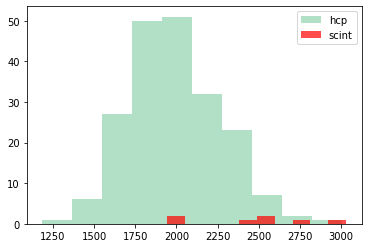

In [16]:
plt.subplot()
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].loss, color='mediumseagreen', alpha=0.4, label='hcp')
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='scint'].loss, color='r', alpha=0.7, label='scint')
plt.legend()

In [8]:
F,p = mannwhitneyu(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].loss, df_encoded_hcp[df_encoded_hcp.Group=='scint'].loss)
print(p)

0.0009656518263277742


#### Reconstruction Error

(array([2., 0., 0., 0., 1., 2., 0., 1., 0., 1.]),
 array([1665., 1776., 1887., 1998., 2109., 2220., 2331., 2442., 2553.,
        2664., 2775.]),
 <BarContainer object of 10 artists>)

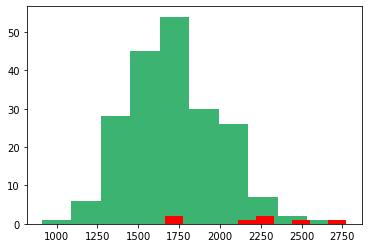

In [9]:
plt.subplot()
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].recon, color='mediumseagreen')
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='scint'].recon, color='r')

In [10]:
F,p = mannwhitneyu(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].recon, df_encoded_hcp[df_encoded_hcp.Group=='scint'].recon)
print(p)

0.0010641807845382547


In [38]:
for sub in scint_list:  
    enc = df_encoded_hcp[df_encoded_hcp['sub']==sub].latent.values[0]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    input_sub = np.copy(df_encoded_hcp[df_encoded_hcp['sub']==sub].input.values[0][0][0])
    error = input_sub - out
    error2 = out - input_sub

#     out[out>0.7] = 1
#     out[out<=0.7] = 0
#     input_sub[input_sub>0.4] = 1
#     input_sub[input_sub<=0.4] = 0
#     error[error>0.4] = 1
#     error[error<=0.4] = 0
#     error2[error2>0.4] = 1
#     error2[error2<=0.4] = 0
    
#     aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/scint_reconstructions/{sub}_out.bck")
#     aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(input_sub), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/scint_reconstructions/{sub}_in.bck")
#     aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/scint_reconstructions/{sub}_error.bck")
#     aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error2), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/scint_reconstructions/{sub}_error_2.bck")

In [36]:
df_encoded_hcp[df_encoded_hcp['sub']==sub].latent.values[0]

array([-0.88676214, -0.48784754, -1.4390776 , -1.4372283 , -0.04870737,
        0.05133346, -3.1419353 , -1.0287993 ,  1.4948337 ,  0.27663913,
        0.95209366,  0.46576056,  1.0228916 ,  0.79359406,  0.57464963,
        0.5635502 , -1.007977  ,  0.00537789,  1.955537  ,  0.1412635 ,
       -1.0936927 ,  0.26869226,  0.96280456,  1.730584  ,  1.9583962 ,
       -3.079853  , -0.21924649,  1.1041701 ,  2.4430156 , -1.1366143 ,
       -1.444688  ,  0.723012  ,  0.51675385, -0.1972867 ,  1.2919794 ,
       -0.22026718, -0.49498752,  0.36612266,  1.3321141 ,  0.55731535,
       -0.09426943, -0.69539   ,  0.68521035, -0.92851305,  1.559329  ,
       -0.6292904 ,  0.9193831 ,  1.8352964 , -1.2292687 , -0.6887645 ,
        0.11147712, -0.8381392 , -1.3534074 ,  0.97472674,  0.33402008,
        1.0151477 , -0.02543553, -0.6794929 , -1.8824781 ,  1.6761746 ,
        1.2865288 ,  1.6262312 , -0.7597217 , -0.93295985,  0.66392994,
       -0.4533263 , -0.93633795,  2.1462219 , -0.70076865, -1.10

In [42]:
input_sub.shape

(80, 80, 96)

In [39]:
np.unique(out)

array([-0.5806395 , -0.50658107, -0.5013812 , ...,  1.353884  ,
        1.3865255 ,  1.4086016 ], dtype=float32)

In [40]:
np.unique(input_sub)

array([0.000000e+00, 3.337860e-05, 3.528595e-05, ..., 9.994670e-01,
       9.995514e-01, 9.996742e-01], dtype=float32)

In [412]:
for sub in non_int_out:  
    enc = df_encoded_hcp[df_encoded_hcp['sub']==sub].latent.values[0]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    input_sub = np.copy(df_encoded_hcp[df_encoded_hcp['sub']==sub].input.values[0][0][0])
    error = input_sub - out
    error2 = out - input_sub

    out[out>0.4] = 1
    out[out<=0.4] = 0
    input_sub[input_sub>0.4] = 1
    input_sub[input_sub<=0.4] = 0
    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/{sub}_out.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(input_sub), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/{sub}_in.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/{sub}_error.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error2), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/{sub}_error_2.bck")

In [10]:
for sub in scint_list:  
    enc = df_encoded_hcp[df_encoded_hcp['sub']==sub].latent.values[0]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    input_sub = np.copy(df_encoded_hcp[df_encoded_hcp['sub']==sub].input.values[0][0][0])
    error = input_sub - out
    error2 = out - input_sub
    
    aims.write(aims.Volume(out), f"/tmp/{sub}_out.nii.gz")
    aims.write(aims.Volume(input_sub), f"/tmp/{sub}_in.nii.gz")
    aims.write(aims.Volume(error), f"/tmp/{sub}_error.nii.gz")
    aims.write(aims.Volume(error2), f"/tmp/{sub}_error_2.nii.gz")

    out[out>0.7] = 1
    out[out<=0.7] = 0
    input_sub[input_sub>0.4] = 1
    input_sub[input_sub<=0.4] = 0
    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/tmp/{sub}_out.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(input_sub), voxel_size=(1,1,1)), f"/tmp/{sub}_in.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error), voxel_size=(1,1,1)), f"/tmp/{sub}_error.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error2), voxel_size=(1,1,1)), f"/tmp/{sub}_error_2.bck")

In [367]:
np.unique(out)

array([-0.0987412 , -0.09408714, -0.08940194, ...,  0.79824066,
        0.803309  ,  0.80662185], dtype=float32)

In [396]:
np.unique(df_encoded_hcp.input[100])

array([0.00000000e+00, 1.11579895e-04, 1.21831894e-04, ...,
       9.99343038e-01, 9.99444604e-01, 9.99658227e-01], dtype=float32)

In [408]:
np.unique(df_encoded_hcp[df_encoded_hcp['sub']==100206].input.values[0])

array([0.0000000e+00, 1.5735626e-05, 2.0980835e-05, ..., 9.9966884e-01,
       9.9988246e-01, 9.9991453e-01], dtype=float32)

In [392]:
df_encoded_hcp[df_encoded_hcp['sub']==100206]

,latent,loss,recon,input,Group,sub
43,"[-1.5166346, 0.5381138, -0.898797, -1.5406448,...",2583,2322,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,hcp,100206


In [402]:
np.unique(df_encoded_hcp.input[2])

array([0.0000000e+00, 1.7642975e-05, 2.4557114e-05, ..., 9.9955142e-01,
       9.9978638e-01, 9.9981844e-01], dtype=float32)

In [406]:
np.unique(df_encoded_hcp.input[8])

array([0.0000000e+00, 1.3113022e-05, 1.7404556e-05, ..., 9.9923635e-01,
       9.9955666e-01, 9.9983978e-01], dtype=float32)

In [373]:
np.unique(df_encoded_hcp[df_encoded_hcp['sub']==100206].input.values[0][0][0])

array([0., 1.], dtype=float32)

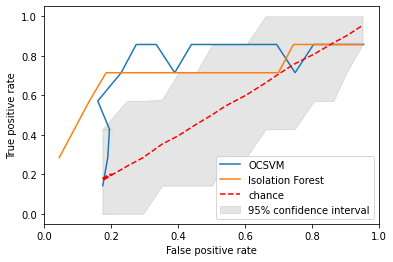

In [332]:
list_loss = np.array(list(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].recon) + list(df_encoded_hcp[df_encoded_hcp.Group=='scint'].recon))
list_loss = np.expand_dims(list_loss, axis=1)

fp_list = {'oc':[], 'lof':[], 'if':[]}
tp_list = {'oc':[], 'lof':[], 'if':[]}
undetected_sub_oc = []
undetected_sub_if = []
fp_random = {}
tp_random = {}

for k in np.arange(0.05, 1, 0.05):
    tp_random[k] = []
    fp_random[k] = []
    clf = OneClassSVM(nu=k).fit(list_loss)
    pred_ctrl = clf.predict(list_loss)[:200]
    pred_scint = clf.predict(list_loss)[200:]
    fp_list['oc'].append(len(pred_ctrl[pred_ctrl==-1])/200)
    tp_list['oc'].append(len(pred_scint[pred_scint==-1])/7)
    undetected_sub_oc.append(np.where(pred_scint[pred_scint==1]))
    nb_outliers = len(clf.predict(list_loss)[clf.predict(list_loss)==-1])
    for i in range(1000):
        rand_outliers = np.array(random.sample(range(207), nb_outliers))
        tp_random[k].append(len(rand_outliers[rand_outliers>=200])/7)
        fp_random[k].append(len(rand_outliers[rand_outliers<200])/200)

    
    clf = IsolationForest(random_state=10, contamination=k).fit(list_loss)
    pred_ctrl = clf.predict(list_loss)[:200]
    pred_scint = clf.predict(list_loss)[200:]
    fp_list['if'].append(len(pred_ctrl[pred_ctrl==-1])/200)
    tp_list['if'].append(len(pred_scint[pred_scint==-1])/7)
    undetected_sub_if.append(np.where(pred_scint[pred_scint==1]))
    
mean_random_fp = [np.mean(fp_random[k]) for k in fp_random.keys()]
mean_random_tp = [np.mean(tp_random[k]) for k in tp_random.keys()]

quantile_5_random_fp = [np.quantile(fp_random[k], 0.05) for k in fp_random.keys()]
quantile_5_random_tp = [np.quantile(tp_random[k], 0.05) for k in tp_random.keys()]

quantile_95_random_fp = [np.quantile(fp_random[k], 0.95) for k in fp_random.keys()]
quantile_95_random_tp = [np.quantile(tp_random[k], 0.95) for k in tp_random.keys()]

plt.subplot()
plt.plot(fp_list['oc'], tp_list['oc'], label='OCSVM')
plt.plot(fp_list['if'], tp_list['if'], label='Isolation Forest')

plt.plot(mean_random_fp, mean_random_tp, linestyle='--', label='chance', c='r')
#plt.plot(quantile_5_random_fp, quantile_5_random_tp, label='5th quantile')
#plt.plot(quantile_95_random_fp, quantile_95_random_tp, label='95th percentile')

plt.fill_between(mean_random_fp, quantile_5_random_tp, quantile_95_random_tp, color='grey', alpha=.2,
            label=f"95% confidence interval")


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

### Control subjects with loss in 95th percentile

In [11]:
percentile_95 = np.quantile(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].loss, 0.95)
uppest_loss = list(df_encoded_hcp[df_encoded_hcp.Group=='hcp'][df_encoded_hcp.loss>percentile_95]['sub'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [25]:
for sub in uppest_loss[0]:
    enc = df_encoded_hcp[df_encoded_hcp['sub']==str(138231)].latent.values[0]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    input_sub = np.copy(df_encoded_hcp[df_encoded_hcp['sub']==str(138231)].input.values[0][0][0])
    error = input_sub - out
    error2 = out - input_sub

    out[out>0.4] = 1
    out[out<=0.4] = 0
    input_sub[input_sub>0.4] = 1
    input_sub[input_sub<=0.4] = 0
    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/ctrl_loss_5/{sub}_out.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(input_sub), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/ctrl_loss_5/{sub}_in.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/ctrl_loss_5/{sub}_error.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error2), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/ctrl_loss_5/{sub}_error_2.bck")

In [344]:
for sub in non_int_out:  
    enc = df_encoded_hcp[df_encoded_hcp['sub']==sub].latent.values[0]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    input_sub = np.copy(df_encoded_hcp[df_encoded_hcp['sub']==sub].input.values[0][0][0])
    error = input_sub - out
    error2 = out - input_sub

    out[out>0.4] = 1
    out[out<=0.4] = 0
    input_sub[input_sub>0.4] = 1
    input_sub[input_sub<=0.4] = 0
    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0

(80, 80, 96)

In [343]:
input_sub.shape

(1, 1, 80, 80, 96)

In [336]:
df_encoded_hcp[df_encoded_hcp['sub']==int(sub)].input.values[0].shape

(1, 1, 80, 80, 96)

In [283]:
df_encoded_hcp[['latent''sub']]

,latent,sub
0,"[1.4987683, -2.3709788, -0.38663277, -1.805903...",932554
1,"[1.2524024, 1.6419047, -0.8353577, -0.12615435...",387959
2,"[-0.11067161, 0.17486379, -0.8502037, 0.352294...",887373
3,"[-0.42013705, 1.1203433, -0.15884572, 0.602573...",704238
4,"[0.39948422, 2.767998, 0.6011206, -0.3999996, ...",169040
5,"[-2.2414525, -0.05261893, -0.3464897, -2.41340...",194746
6,"[-3.298634, -2.1918232, -0.00073624577, -0.599...",127832
7,"[-0.20477563, 1.008311, -0.500729, 0.8531343, ...",206727
8,"[-0.3006783, 0.7252304, 0.14118715, -0.7949637...",679770
9,"[0.40259424, 0.4275403, 0.40569162, 0.753658, ...",210112


### Application on on-handed subjects

In [85]:
X_oh = np.array(list(df_encoded_oh['latent']))
labels_oh = np.array(df_encoded_oh['Group'])

X_embedded_oh = TSNE(n_components=2, random_state=12, perplexity=12).fit_transform(X_oh)

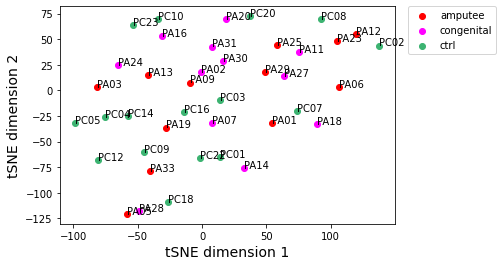

In [86]:
arr = X_embedded_oh
color_dict = {'ctrl':'mediumseagreen', 'amputee': 'red', 'congenital':'magenta'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_oh):
    ix = np.where(labels_oh == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

subjects_name_oh = list(df_encoded_oh['sub'])
for i, txt in enumerate(subjects_name_oh):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

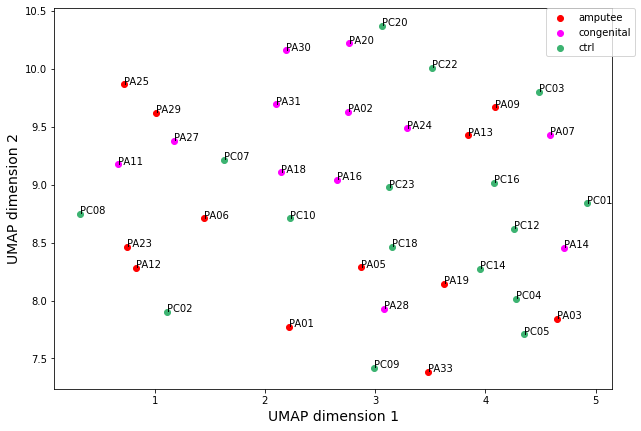

In [352]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_oh)

arr = embedding
color_dict = {'ctrl':'mediumseagreen', 'amputee': 'red', 'congenital':'magenta'}

fig = plt.figure(figsize=(10,7))
ax = fig.subplots()

for g in np.unique(labels_oh):
    ix = np.where(labels_oh == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_oh):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [88]:
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='ctrl'].loss, df_encoded_oh[df_encoded_oh.Group=='congenital'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='amputee'].loss, df_encoded_oh[df_encoded_oh.Group=='congenital'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='amputee'].loss, df_encoded_oh[df_encoded_oh.Group=='ctrl'].loss)
print(p)

0.18266256684598342
0.4199299862700017
0.2358950681666513


(array([2., 0., 1., 2., 1., 2., 1., 1., 1., 1.]),
 array([1575. , 1630.3, 1685.6, 1740.9, 1796.2, 1851.5, 1906.8, 1962.1,
        2017.4, 2072.7, 2128. ]),
 <BarContainer object of 10 artists>)

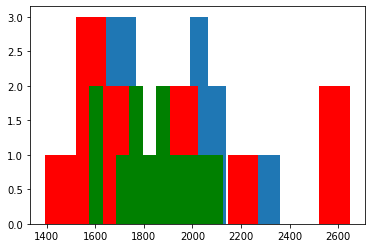

In [89]:
plt.subplot()
plt.hist(df_encoded_oh[df_encoded_oh.Group=='ctrl'].loss)
plt.hist(df_encoded_oh[df_encoded_oh.Group=='amputee'].loss, color='r')
plt.hist(df_encoded_oh[df_encoded_oh.Group=='congenital'].loss, color='g')

In [90]:
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='ctrl'].loss, df_encoded_oh[df_encoded_oh.Group=='congenital'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='amputee'].loss, df_encoded_oh[df_encoded_oh.Group=='congenital'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='amputee'].loss, df_encoded_oh[df_encoded_oh.Group=='ctrl'].loss)
print(p)

0.18266256684598342
0.4199299862700017
0.2358950681666513


(array([2., 0., 1., 2., 1., 2., 1., 1., 1., 1.]),
 array([1300. , 1354.4, 1408.8, 1463.2, 1517.6, 1572. , 1626.4, 1680.8,
        1735.2, 1789.6, 1844. ]),
 <BarContainer object of 10 artists>)

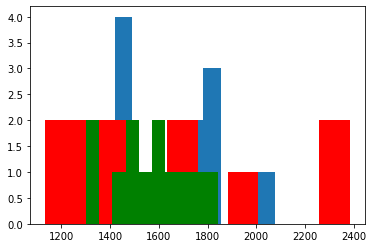

In [91]:
plt.subplot()
plt.hist(df_encoded_oh[df_encoded_oh.Group=='ctrl'].recon)
plt.hist(df_encoded_oh[df_encoded_oh.Group=='amputee'].recon, color='r')
plt.hist(df_encoded_oh[df_encoded_oh.Group=='congenital'].recon, color='g')

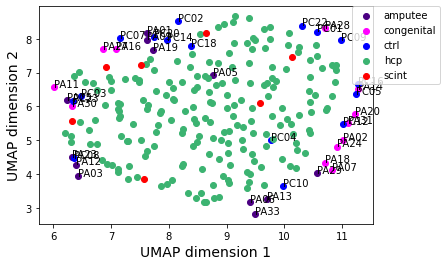

In [103]:
embedding_oh = reducer.transform(X_oh)

color_dict_oh = {'ctrl':'blue', 'amputee': 'indigo', 'congenital':'magenta'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_oh):
    ix = np.where(labels_oh == g)
    x = [embedding_oh[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding_oh[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict_oh[g], label = g_lab)
    
for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [embedding[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_oh):
    ax.annotate(txt, (embedding_oh[i][0], embedding_oh[i][1]))
    
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### On EUAIMS

In [120]:
aims_data = pd.read_pickle(os.path.join(data_dir, "encoded_aims.pkl"))

In [121]:
df_encoded_aims = aims_data
X_aims = np.array(list(aims_data['latent']))
labels_aims = np.array(aims_data['Group'])

X_embedded_aims = TSNE(n_components=2, random_state=12, perplexity=30).fit_transform(X_aims)

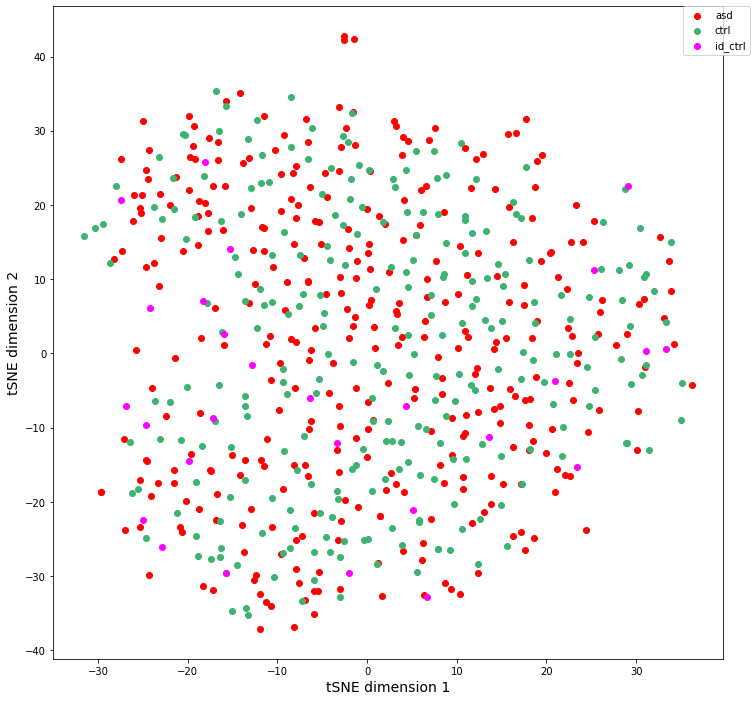

In [123]:
arr = X_embedded_aims
color_dict = {'ctrl':'mediumseagreen', 'asd': 'red', 'id_ctrl':'magenta'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels_aims):
    ix = np.where(labels_aims == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

subjects_name_aims = list(df_encoded_aims['sub'])
#for i, txt in enumerate(subjects_name_aims):
#    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [197]:
labels_aims = pd.read_csv('/neurospin/dico/lguillon/aims_detection/info_subjects.csv')

In [198]:
aims_data['sub'] = aims_data['sub'].astype(int)
aims_data_site = pd.merge(labels_aims, df_encoded_aims, left_on='subjects', right_on='sub')[['subjects', 't1_group', 't1_asd_thresh', 't1_site', 't1_schedule_enrol', 't1_handedness_score', 't1_css_total', 'latent', 'loss', 'recon', 'input', 'Group', 'sub']]

In [243]:
# aims_data_site['t1_handedness_score'] = [aims_data_site['t1_handedness_score'][k].replace(',', '.') for k in range(len(aims_data_site))]
# aims_data_site['t1_handedness_score'] = aims_data_site['t1_handedness_score'].astype(float)
aims_data_rome = aims_data_site[(aims_data_site.t1_site=='Mannheim') | (aims_data_site.t1_site=='Nijmegen')][aims_data_site.t1_schedule_enrol=='Adults'][aims_data_site.t1_css_total.astype(int)>5][aims_data_site.t1_handedness_score>0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [336]:
#aims_data_rome = aims_data_site[(aims_data_site.t1_site=='Utrecht')][(aims_data_site.t1_schedule_enrol=='Adults') |(aims_data_site.t1_schedule_enrol=='Adolescents')][aims_data_site.t1_css_total.astype(int)>5][(aims_data_site.Group == 'ctrl') | (aims_data_site.Group=='asd')][aims_data_site.t1_handedness_score>0]

#aims_data_rome = aims_data_site[(aims_data_site.t1_site=='Utrecht') | (aims_data_site.t1_site=='KCL')][aims_data_site.t1_schedule_enrol=='Adults'][aims_data_site.t1_css_total.astype(int)>6][aims_data_site.t1_handedness_score>0]
aims_data_rome = aims_data_site[aims_data_site.t1_site=='Cambridge'][(aims_data_site.t1_schedule_enrol=='Adults')|(aims_data_site.t1_schedule_enrol=='Adolescents')][aims_data_site.t1_css_total.astype(int)>6][aims_data_site.t1_handedness_score>0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [337]:
subjects_name_aims = list(aims_data_rome['sub'])

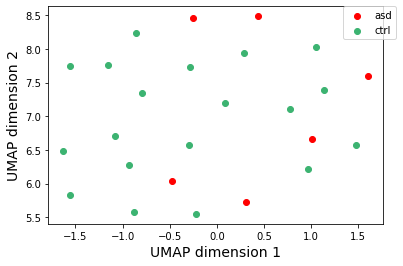

In [338]:
X_rome = np.array(list(aims_data_rome.latent))
labels_aims = np.array(list(aims_data_rome.Group))

reducer = umap.UMAP(random_state=53)
embedding = reducer.fit_transform(X_rome)

arr = embedding
color_dict = {'ctrl':'mediumseagreen', 'asd': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_aims):
    ix = np.where(labels_aims == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
# for i, txt in enumerate(subjects_name_aims):
#     ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

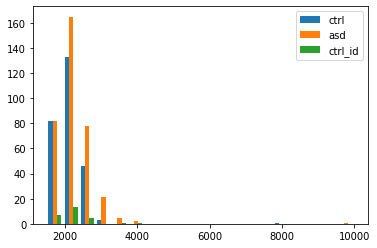

In [126]:
bins = np.linspace(1500, 10000, 20)

plt.hist([df_encoded_aims[df_encoded_aims.Group=='ctrl'].loss, df_encoded_aims[df_encoded_aims.Group=='asd'].loss, df_encoded_aims[df_encoded_aims.Group=='id_ctrl'].loss], bins, label=['ctrl', 'asd', 'ctrl_id'])
plt.legend(loc='upper right')
plt.show()

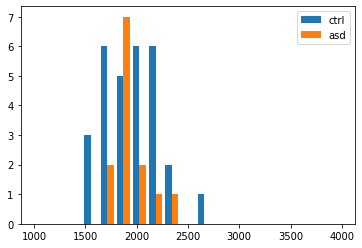

In [327]:
bins = np.linspace(1000, 4000, 20)

plt.hist([aims_data_rome[aims_data_rome.Group=='ctrl'].loss, aims_data_rome[aims_data_rome.Group=='asd'].loss], bins, label=['ctrl', 'asd'])
plt.legend(loc='upper right')
plt.show()

In [326]:
ttest_ind(list(aims_data_rome[aims_data_rome.Group=='ctrl'].loss), list(aims_data_rome[aims_data_rome.Group=='asd'].loss))

Ttest_indResult(statistic=0.8091783832024007, pvalue=0.42319981695034237)

In [127]:
F,p = mannwhitneyu(list(df_encoded_aims[df_encoded_aims.Group=='ctrl'].loss), list(df_encoded_aims[df_encoded_aims.Group=='asd'].loss))
print(p)
F,p = mannwhitneyu(list(df_encoded_aims[df_encoded_aims.Group=='ctrl'].loss), list(df_encoded_aims[df_encoded_aims.Group=='id_ctrl'].loss))
print(p)

0.00015137006349626346
0.4039396894292667


In [128]:
ttest_ind(list(df_encoded_aims[df_encoded_aims.Group=='ctrl'].loss), list(df_encoded_aims[df_encoded_aims.Group=='asd'].loss))

Ttest_indResult(statistic=-2.9013694768374534, pvalue=0.0038475992624235943)

In [212]:
len(df_encoded_aims[df_encoded_aims.Group=='asd'])

354

In [259]:
results['scint'].keys()

dict_keys(['138231', '510225', '159946', '140319', '212419', '199251', '111009'])

In [450]:
losses['scint']

[3152, 3376, 3060, 2545, 3610, 3016, 3605]

In [216]:
from scipy import stats

In [452]:
print(np.std(losses['hcp']))
print(np.std(losses['scint']))

330.64370914928963
347.9944287614093


In [187]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
for k in range(200, 207):
    print(neigh.kneighbors(np.expand_dims(X[k], axis=0)))

(array([[ 0.        , 11.69054825, 12.00801633, 13.4761403 ]]), array([[200, 206, 210, 224]]))
(array([[ 0.        , 13.45366735, 13.96529384, 14.17247194]]), array([[201, 215, 208, 214]]))
(array([[ 0.        , 14.1431712 , 14.67249479, 14.83832237]]), array([[202, 218, 228, 247]]))
(array([[ 0.        , 13.09613229, 13.41196201, 13.99237086]]), array([[203, 221, 215, 217]]))
(array([[ 0.        , 14.99152268, 15.96027309, 16.04859976]]), array([[204,  28, 127, 215]]))
(array([[ 0.        , 13.33081389, 13.67092942, 13.76308412]]), array([[205, 210, 208, 226]]))
(array([[ 0.        , 11.69054825, 13.38221995, 13.43525141]]), array([[206, 200, 210, 224]]))


In [188]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
for k in range(200, 207):
    print(neigh.kneighbors(np.expand_dims(X[k], axis=0)))

(array([[ 0.        , 11.69054825, 12.00801633, 13.4761403 ]]), array([[200, 206, 210, 224]]))
(array([[ 0.        , 13.45366735, 13.96529384, 14.17247194]]), array([[201, 215, 208, 214]]))
(array([[ 0.        , 14.1431712 , 14.67249479, 14.83832237]]), array([[202, 218, 228, 247]]))
(array([[ 0.        , 13.09613229, 13.41196201, 13.99237086]]), array([[203, 221, 215, 217]]))
(array([[ 0.        , 14.99152268, 15.96027309, 16.04859976]]), array([[204,  28, 127, 215]]))
(array([[ 0.        , 13.33081389, 13.67092942, 13.76308412]]), array([[205, 210, 208, 226]]))
(array([[ 0.        , 11.69054825, 13.38221995, 13.43525141]]), array([[206, 200, 210, 224]]))


In [390]:
sub['hcp'][49]

168139

In [280]:
filenames_scint

array(['138231', '510225', '159946', '140319', '212419', '199251',
       '111009'], dtype='<U6')

### Study of reconstruction error as anomaly score

In [394]:
idx = np.where(np.array(losses['hcp'])>3000)

In [401]:
sub['hcp'][idx]

array([887373, 704238, 679770, 124422, 872158, 942658, 168038, 802844,
       116221, 100206, 172534, 329440, 180937, 965367, 351938, 185038,
       145632, 199958, 121416, 731140, 135730, 104012, 117122, 176239,
       123824, 275645, 189450, 167440, 891667, 139839, 120010, 510326,
       456346, 573249, 175035, 211720])

In [464]:
enc = encoded['hcp'][10]

In [417]:
enc.shape

(20,)

In [465]:
arr_out = []
values = []

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

# arr_out = np.array(arr_out)
# np.save(f"/volatile/arr_out.npy", arr_out)
# np.save('/volatile/arr_label.npy', np.array(values))

In [466]:
out[out>0.5] = 1
out[out<=0.5] = 0

In [467]:
aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/volatile/bucket_test.bck")